# Zonal Statistics

Having generated a Cloud-Optimized GeoTiff (COG) file containing our NDVI calculations, we are now ready to return to our redlining data and determine if indeed we still see the legacy of those racist practices more than 50 years after they were outlawed. 

The aggregation of raster pixels grouped by their containing polygons is something like the spatial equivalent of our `.group_by()` + `.aggregate()` operations in ibis, where the raster defines the values and the polygons define the groups.  

To compute the average NDVI in each polygon, we will introduce yet another module -- `exactextract`.  This package can efficiently compute summary statistics for each polygon given a raster image.  While several different modules can perform this kind of aggregation, [`exactextract`](https://isciences.github.io/exactextract/index.html) is quite fast and scalable, using an efficient algorithm in C++, and gets it's name for an ability to account for fractional coverage of a raster cell by a polygon, like so. 

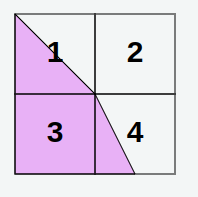

In [1]:
from exactextract import exact_extract
import ibis
from ibis import _


We begin as before by grabbing our remote city data.  Here we have added an additional filter to focus only on residental data, as non-residental sites are not graded even though they are still marked on the map. 

In [2]:
con = ibis.duckdb.connect(extensions=["spatial"])

redlines = (
    con
    .read_geo("/vsicurl/https://dsl.richmond.edu/panorama/redlining/static/mappinginequality.gpkg")
    .filter(_.city == "New Haven", _.residential)
   )



Spatial operations such as overlaying polygons on the raster requires that the two datasets have **matching coordinate reference systems**.  While we have already transformed our raster data to the 'longitude, latitude' coordinates, EPSG:4326, we need to manually add this annotation to declare that our parquet data is already using this projection as well.  We do this with `.set_crs()` option on `geopandas` object:

In [3]:
city =  redlines.execute().set_crs("EPSG:4326")

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

The `exact_extract` [documentation](https://isciences.github.io/exactextract/autoapi/exactextract/exact_extract/index.html) shows this is a flexible method able to take a raster and vector input and compute a range of summary statistics.  The method is also somewhat flexible in how it formats the output -- here we indicate we want the output formulated as a 'geopandas' object, keeping the geometry column and other useful columns from the original input data.




In [4]:
city_stats = exact_extract("ndvi.tif", 
                           city, 
                           ["mean"], 
                           include_geom = True,
                           include_cols=["label", "grade", "city", "fill"],
                           output="pandas")

city_stats.head()

/opt/miniforge3/lib/python3.12/site-packages/exactextract/exact_extract.py:330: RuntimeWarning: Spatial reference system of input features does not exactly match raster.
  warnings.warn(


,label,grade,city,fill,mean,geometry
0,A1,A,New Haven,#76a865,0.709624,"MULTIPOLYGON (((-72.9 41.36885, -72.90325 41.3..."
1,A2,A,New Haven,#76a865,0.761685,"MULTIPOLYGON (((-72.89401 41.36331, -72.89256 ..."
2,A3,A,New Haven,#76a865,0.665130,"MULTIPOLYGON (((-72.90981 41.35949, -72.90284 ..."
3,A4,A,New Haven,#76a865,0.751388,"MULTIPOLYGON (((-72.90284 41.35795, -72.8999 4..."
4,A5,A,New Haven,#76a865,0.742981,"MULTIPOLYGON (((-72.89801 41.3493, -72.89883 4..."


We will write out this updated file as a parquet dataset. This provides both a mechanism to store our completed calculation and an easy way to go back from `geopandas` into `ibis`.  

In [5]:
city_stats.to_parquet("new_haven_stats.parquet")

We can bring our data back into ibis, where we can do our familiar manipulations.

In [6]:
city = con.read_parquet("new_haven_stats.parquet")

 and we are finally ready to summarize the data to determine if the spectre of redlining remains: on average, are A grades still greener than D grades?  Construct the rest of the `ibis` code to compute the average NDVI by grade.